# This notebook is for some of the plots I used in the blog.

In [186]:
import pandas as pd
import numpy as np
from datetime import date
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
bitcoin =pd.read_csv('bitcoin.csv').drop('Unnamed: 0',axis=1)
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
bitcoin.set_index('Date',inplace=True)
bits_log_shift = (np.log(bitcoin['Price']) - np.log(bitcoin['Price']).shift()).dropna()
ethereum = pd.read_csv('ethereum.csv').drop('Unnamed: 0',axis=1)
ethereum['Date'] = pd.to_datetime(ethereum['Date'])
ethereum.set_index('Date',inplace=True)
eth_log_shift = (np.log(ethereum['Price']) - np.log(ethereum['Price']).shift()).dropna()

eth = pd.read_csv('ethereum_data_to_plot.csv').drop('Unnamed: 0',axis=1)
eth.rename(columns={'Predicted with ARIMA':'ARIMA prediction','Predicted with Neural Nets':'Neural Net Prediction'},inplace=True)
eth['Date'] = pd.to_datetime(eth['Date'])
eth.set_index('Date',inplace=True)

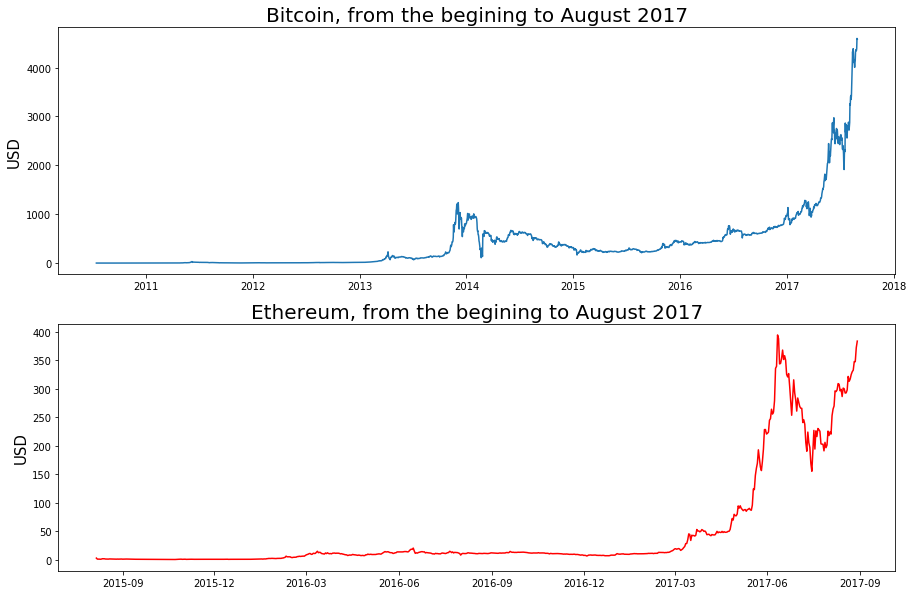

In [178]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(bitcoin.index,bitcoin['Price'])
plt.ylabel('USD',fontsize=15)
plt.title('Bitcoin, from the begining to August 2017',fontsize=20)
plt.subplot(2,1,2)
plt.plot(ethereum.index,ethereum['Price'],color='red')
plt.title('Ethereum, from the begining to August 2017',fontsize=20)
plt.ylabel('USD',fontsize=15)
plt.savefig('fullplots.png')
plt.show()

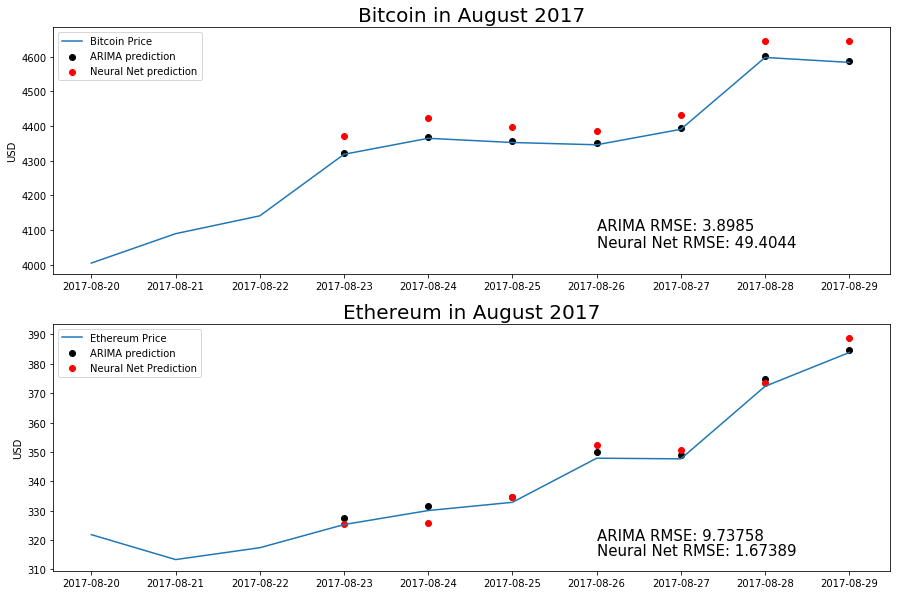

In [179]:
date = '8-20-2017'

import matplotlib.dates as mdates

bitcoin_ARIMA = [4321.92,4368.25,4356.23,4349.69,4394.20,4601.04,4586.36]
bitcoin_neural_net = [4369.75,4423.16,4397.79,4384.69,4430.15,4643.98,4643.34]

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)

plt.plot(bitcoin.loc[date:].index,bitcoin['Price'].loc[date:],label='Bitcoin Price')
plt.scatter(bitcoin.loc['8-23-2017':].index,bitcoin_ARIMA,color='black',label='ARIMA prediction')
plt.scatter(bitcoin.loc['8-23-2017':].index,bitcoin_neural_net,color='red',label='Neural Net prediction')

plt.text(x='8-26-2017',y=4100,s='ARIMA RMSE: 3.8985',fontsize=15)
plt.text(x='8-26-2017',y=4050,s='Neural Net RMSE: 49.4044',fontsize=15)

plt.ylabel('USD')
plt.title('Bitcoin in August 2017',fontsize=20)
plt.legend()
###### Now for ethereum
plt.subplot(2,1,2)
plt.plot(ethereum.loc[date:].index,ethereum['Price'].loc[date:],label='Ethereum Price')
plt.scatter(eth.loc['8-23-2017':].index,eth[eth.columns[1]].loc['8-23-2017':],label='ARIMA prediction',color='black')
plt.scatter(eth.loc['8-23-2017':].index,eth[eth.columns[2]].loc['8-23-2017':],label='Neural Net Prediction',color='red')
plt.title('Ethereum in August 2017',fontsize=20)
plt.text(x='8-26-2017',y=320,s='ARIMA RMSE: 9.73758',fontsize=15)
plt.text(x='8-26-2017',y=315,s='Neural Net RMSE: 1.67389',fontsize=15)
plt.ylabel('USD')
plt.legend()
plt.savefig('predictions.png')
plt.show()

In [134]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries,name,comment):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(str(comment)+' Rolling Mean & Standard Deviation')
    plt.xticks(rotation=45)
    plt.show(block=False)
    plt.savefig(str(name)+'.png')
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,regression = 'ct', autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    #print dfoutput
    return dfoutput

#test_stationarity(bits_log_shift,'Bitcoin_stationary','Bitcoin Stationary')

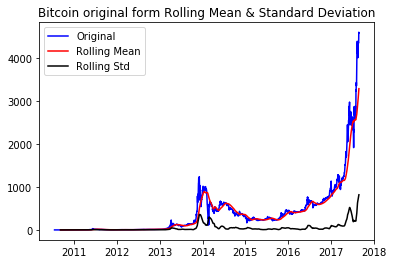

Results of Dickey-Fuller Test:


Test Statistic                    3.433511
p-value                           1.000000
#Lags Used                       28.000000
Number of Observations Used    2573.000000
Critical Value (1%)              -3.962293
Critical Value (5%)              -3.412198
Critical Value (10%)             -3.128055
dtype: float64

In [129]:
test_stationarity(bitcoin['Price'],'Bitcoin_original','Bitcoin original form')

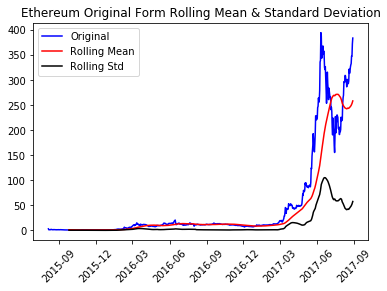

Results of Dickey-Fuller Test:


Test Statistic                  -1.669357
p-value                          0.764110
#Lags Used                      20.000000
Number of Observations Used    734.000000
Critical Value (1%)             -3.971157
Critical Value (5%)             -3.416488
Critical Value (10%)            -3.130580
dtype: float64

In [135]:
test_stationarity(ethereum['Price'],'Ethereum_original','Ethereum Original Form')

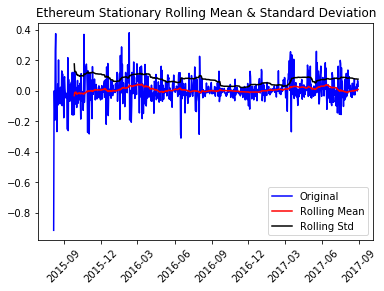

Results of Dickey-Fuller Test:


Test Statistic                -1.533333e+01
p-value                        1.575305e-22
#Lags Used                     2.000000e+00
Number of Observations Used    7.510000e+02
Critical Value (1%)           -3.970875e+00
Critical Value (5%)           -3.416352e+00
Critical Value (10%)          -3.130500e+00
dtype: float64

In [136]:
test_stationarity(eth_log_shift,'Ethereum_transformed','Ethereum Stationary')

Ethereum Dickey-Fuller Test:|Results when transformed to stationary|Results results before stationary (failing)
------|---------|--------|
Test Statistic| -1.533333e+01|3.433511
p-value|1.575305e-22|1.00000
Number Lags Used|2.000000|28.0000
Number of Observations Used| 751.0000|2573.000000
Critical Value (1%)|-3.970875|-3.962293
Critical Value (5%)|-3.416352|-3.412198
Critical Value (10%)|-3.1305000|-3.128055

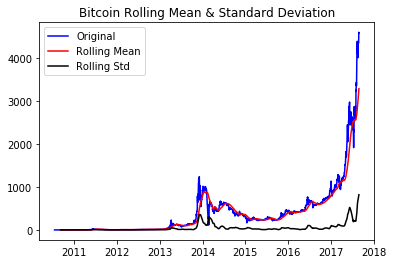

In [184]:
def test_stationarity_image(timeseries,comment,r):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(str(comment)+' Rolling Mean & Standard Deviation')
    plt.xticks(rotation=r)
    return plt.show(block=False)
    
test_stationarity_image(bitcoin['Price'],'Bitcoin',0)

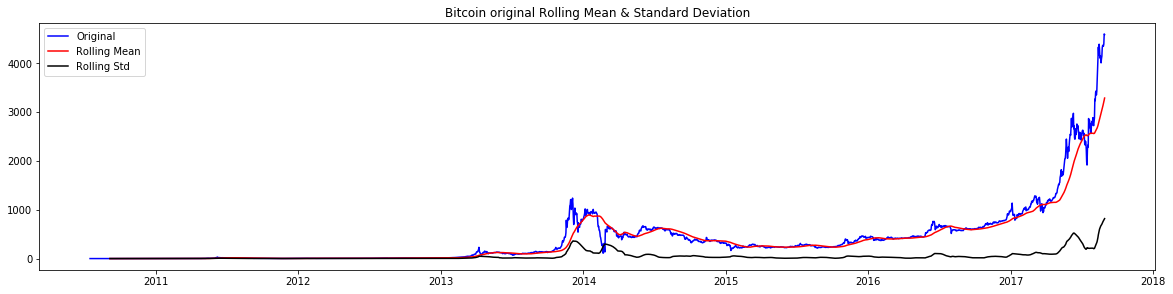

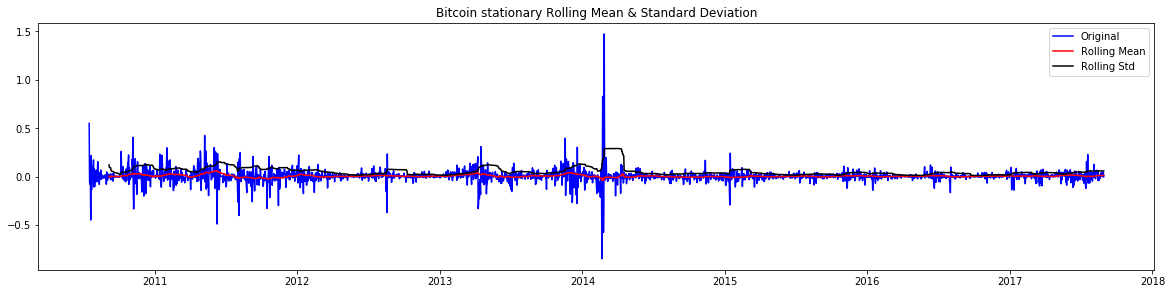

In [185]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
test_stationarity_image(bitcoin['Price'],'Bitcoin original',0)
plt.figure(figsize=(20,10))
plt.subplot(2,1,2)
test_stationarity_image(bits_log_shift,'Bitcoin stationary',0)
plt.show()
plt.savefig('Dickey_Fuller_tests.png')